<a href="https://colab.research.google.com/github/bforsbe/SK2534/blob/main/kinetics_seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Kinetics in Molecular Systems — Seminar Notebook

**Goals (short):**
- Connect thermodynamics (populations) and kinetics (rates).
- Compute rates from energy barriers (Eyring / Arrhenius) and explore temperature dependence.
- Discover how rates combine for **serial** vs **parallel** barriers (students will *derive/discover* the rules).
- Build small kinetic networks (rate matrices) and compute steady states and mean first passage times (MFPT).

This notebook is split into **separate runnable cells** (explanation + code). Each section contains concise derivations and exercises. Run cells in order.



## 1) Boltzmann populations (Thermodynamics refresher)

At equilibrium, the probability (population) of being in microstate $i$ with energy $E_i$
is given by the Boltzmann distribution:
$$
p_i = \frac{e^{-E_i / (k_B T)}}{\sum_j e^{-E_j / (k_B T)}}
$$

- $k_B$ is the Boltzmann constant.
- Use these populations as the thermodynamic *equilibrium* — they **do not** contain time information about dynamic processes like folding or forward and reverse rates.


In [101]:

#@title Compute regular Boltzmann populations
# Compute Boltzmann populations for an example set of energies
import numpy as np

kB = 1.380649e-23  # J/K (for clarity when using J units)
R = 8.314462618  # J/mol/K (useful if energies are in J/mol)
T = 300.0  # K

# Example energies in kJ/mol (convert to J/mol for use with R)
energies_kjmol = np.array([0.0, 5.0, 10.0])  # kJ/mol
energies = energies_kjmol * 1000.0  # J/mol

boltz = np.exp(-energies / (R * T))
probs = boltz / boltz.sum()

print('Energies (kJ/mol):', energies_kjmol)
print('Equilibrium populations:', np.round(probs, 4))


Energies (kJ/mol): [ 0.  5. 10.]
Equilibrium populations: [0.8674 0.1169 0.0157]



## Single barrier

In a previous seminar we derived the metropolis criterion to accept a move to a higher state. We based that on a two-state system where the rates needed to balanace to fulfil the Bolztmann factors. We found that the probablity was
$$k = \exp\left(-\frac{\Delta H}{RT}\right)$$
where $\Delta H$ was the differnece in energy, whereas the probability of going the other way 100%. If we generalize this to many nearby states and all the way to a continuum, it gets very complicated. We have to solve something called the **Fokker–Planck / Smoluchowski equation**, and take it in the limit of **low-temperature / high-barrier limit**, which leads to something called **Karmers classic rate formula**. We don't go into this here, but one neat thing is that this preserves the fundamental form of the expression, and encapsulates aspects about the landscape and other things in a simple frefactor, that we can call $A$. This is the then exactly the Arrhenius equation:

**Arrhenius (simple, empirical):**
$$k = A \cdot \exp\left(-\frac{E_a}{R T}\right)$$
- $A$ is the pre-exponential factor (frequency prefactor).
- $E_a$ is the activation energy (J/mol).



## Arrhenius Plots

An **Arrhenius plot** is a way to test how rates depend on temperature.

We start with the Arrhenius equation:
$$
k = A \, e^{-\frac{E_a}{RT}}
$$

Taking logs:
$$
\ln k = \ln A - \frac{E_a}{R}\frac{1}{T}
$$

If we plot **ln(k)** vs **1/T**, we should see a straight line:
- **Slope:** $-E_a/R$ (gives activation energy $E_a$)  
- **Intercept:** $\ln A$ (gives the prefactor $A$)  

### experiments to measure k

The reaction rate is the change in concentration of reactants or products per unit time, so to measure $k$in practise you need something you can observe and quantify over time, for example:

- Spectroscopy: UV–Vis absorbance, fluorescence, or NMR signals that change with concentration.
- Gas evolution: Measure pressure or volume of gas if the reaction produces/consumes a gas.
- Titration: Quench the reaction at specific times and measure concentration.
- Conductivity or pH: If ionic species are produced/consumed.



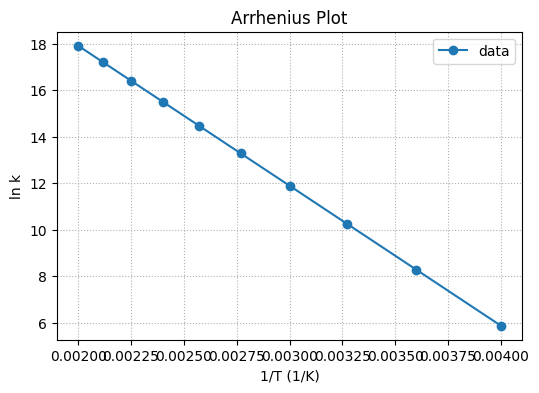

Fitted Ea = 50.00 kJ/mol (true 50.00)


In [102]:
#@title Estimating Ea from synthetic data using an Arrhenius plot
import numpy as np
import matplotlib.pyplot as plt

R = 8.314  # J/mol/K
Ea = 50e3  # activation energy, J/mol
A = 1e13   # pre-exponential factor, 1/s

# Temperature range
T = np.linspace(250, 500, 10)  # Kelvin
k = A * np.exp(-Ea/(R*T))      # rate constants

# Arrhenius plot: ln(k) vs 1/T
plt.figure(figsize=(6,4))
plt.plot(1/T, np.log(k), 'o-', label='data')
plt.xlabel('1/T (1/K)')
plt.ylabel('ln k')
plt.title('Arrhenius Plot')
plt.grid(True, ls=':')
plt.legend()
plt.show()

# Linear regression to extract Ea and A
coeffs = np.polyfit(1/T, np.log(k), 1)
slope, intercept = coeffs
Ea_fit = -slope * R
A_fit = np.exp(intercept)

print(f"Fitted Ea = {Ea_fit/1000:.2f} kJ/mol (true {Ea/1000:.2f})")
#print(f"Fitted A  = {A_fit:.2e} 1/s (true {A:.2e})")


## Serial barriers (A → I → B)

But a single transtion state seems crazy - protein folding must be a very complicated process, not just a two-state hop. Let's see what happens if we add just one more hop, going to an intermediate state $I$ before getting from $A$ to $B$:

If $A$→$I$ occurs with rate $k_1$ and $I$→$B$ with rate $k_2$ (no branching or backflow), then the **expected time** to go from $A$ to $B$ is the sum of expected times for the two steps:
$$
\tau = \frac{1}{k_1} + \frac{1}{k_2}.
$$
Thus the **effective rate** (one over the mean time) is
$$
k_{\mathrm{eff}} = \frac{1}{\tau} = \frac{1}{\frac{1}{k_1} + \frac{1}{k_2}} = \frac{k_1 k_2}{k_1 + k_2}.
$$

**Caveat:** This is an approximation under certain assumptions, but to first approximation accurate. This expression is clearly dominated by the **slower** rate, corresponding to the higher barrier. The only time that is not the case is when multiple barriers are close in energy, but even then the most important thing to remember still applies; we can think of an effective rate and barrier. This generalizes, so that we can always think of it as such, no matter how many barriers.

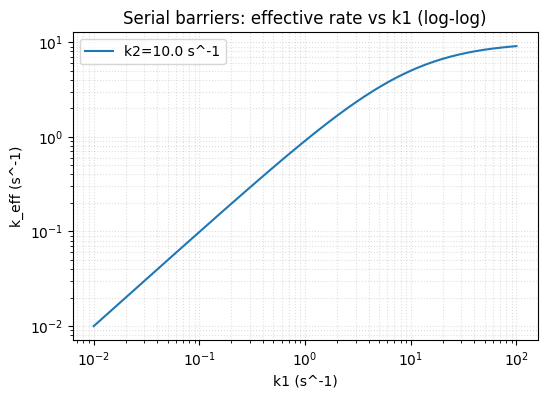

k1=  0.01, k2= 10.00 => k_eff=0.0100 s^-1
k1=  0.10, k2= 10.00 => k_eff=0.0990 s^-1
k1=  1.00, k2= 10.00 => k_eff=0.9091 s^-1
k1= 10.00, k2= 10.00 => k_eff=5.0000 s^-1
k1=100.00, k2= 10.00 => k_eff=9.0909 s^-1


In [103]:

#@title  Serial barriers: numerical exploration
import numpy as np
import matplotlib.pyplot as plt

def serial_keff(k1, k2):
    tau = 1.0/k1 + 1.0/k2
    return 1.0/tau

k2 = 10.0  # s^-1 (fixed)
ks = np.logspace(-2, 2, 200)  # sweep k1
keff_serial = [serial_keff(k1, k2) for k1 in ks]

plt.figure(figsize=(6,4))
plt.loglog(ks, keff_serial, label=f'k2={k2} s^-1')
plt.xlabel('k1 (s^-1)')
plt.ylabel('k_eff (s^-1)')
plt.title('Serial barriers: effective rate vs k1 (log-log)')
plt.grid(True, which='both', ls=':', alpha=0.4)
plt.legend()
plt.show()

# Print a couple of values to show limiting behavior
for k1 in [0.01, 0.1, 1.0, 10.0, 100.0]:
    print(f'k1={k1:6.2f}, k2={k2:6.2f} => k_eff={serial_keff(k1,k2):.4f} s^-1')


## Parallel barriers (competing pathways)

If A can go to B via two independent channels with rates \(k_1\) and \(k_2\), the time to leave A
and reach B is the minimum of two independent exponential waiting times. The minimum of independent exponentials
is exponential with rate equal to the sum of the rates, hence:
$$
k_{\mathrm{eff}} = k_1 + k_2.
$$

**Branching ratio:** the fraction of transitions taking path 1 is
$$
P(\text{path 1}) = \frac{k_1}{k_1 + k_2},
$$
and similarly for path 2. This means that we effectivley lower the barrier by having two options! Not too surprising perhaps, but again, the important part is that we can think of an effective rate even in the prescence of multiple parallel pathways to go from $A$to $B$, as in the folded-unfolded transtion.



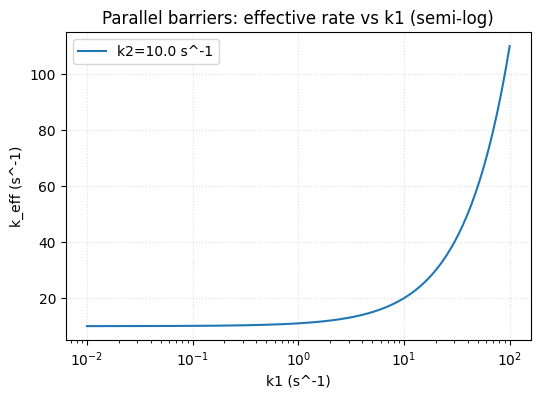

k1=  0.01, k2= 10.00 => k_eff=10.0100 s^-1, frac path1=0.001
k1=  0.10, k2= 10.00 => k_eff=10.1000 s^-1, frac path1=0.010
k1=  1.00, k2= 10.00 => k_eff=11.0000 s^-1, frac path1=0.091
k1= 10.00, k2= 10.00 => k_eff=20.0000 s^-1, frac path1=0.500
k1=100.00, k2= 10.00 => k_eff=110.0000 s^-1, frac path1=0.909


In [104]:

#@title Parallel barriers: numerical exploration
import numpy as np
import matplotlib.pyplot as plt

def parallel_keff(k1, k2):
    return k1 + k2

k2 = 10.0  # s^-1 fixed
ks = np.logspace(-2, 2, 200)
keff_parallel = [parallel_keff(k1, k2) for k1 in ks]

plt.figure(figsize=(6,4))
plt.semilogx(ks, keff_parallel, label=f'k2={k2} s^-1')
plt.xlabel('k1 (s^-1)')
plt.ylabel('k_eff (s^-1)')
plt.title('Parallel barriers: effective rate vs k1 (semi-log)')
plt.grid(True, ls=':', alpha=0.4)
plt.legend()
plt.show()

# branching fraction examples
for k1 in [0.01, 0.1, 1.0, 10.0, 100.0]:
    frac1 = k1 / (k1 + k2)
    print(f'k1={k1:6.2f}, k2={k2:6.2f} => k_eff={parallel_keff(k1,k2):.4f} s^-1, frac path1={frac1:.3f}')


BLa

## Beyond Temperature: Other Factors Affecting Rates

So far, we've focused on how temperature affects reaction rates through the Arrhenius equation and energy barriers. However, other factors can also significantly influence reaction kinetics by changing the stability of different states (reactant, product, and transition state).

One common factor used in protein folding studies is **chemical denaturant** (like urea or guanidine hydrochloride). Denaturants destabilize the folded state relative to the unfolded state, and can also affect the stability of the transition state.

By measuring reaction rates (like folding and unfolding rates) at different denaturant concentrations, we can gain insight into how the stability of the transition state is coupled to the folding/unfolding process. This leads us to the **Chevron plot**, which analyzes how folding and unfolding rates change with denaturant concentration.

In the context of our multi-state systems, folding and unfolding can often be viewed as **competing pathways** (parallel barriers). The observed **effective rate** is the sum of the rates of these competing processes, just like we saw before.

 A Chevron plot helps visualize how the dominance shifts between folding and unfolding as the denaturant concentration changes, revealing information about the energy landscape and the position of the transition state along the reaction coordinate.

## Beyond Temperature: Other Factors Affecting Rates

So far, we've focused on how temperature affects reaction rates through the Arrhenius equation and energy barriers. However, other factors can also significantly influence reaction kinetics by changing the stability of different states (reactant, product, and transition state).

One common factor used in protein folding studies is **chemical denaturant** (like urea or guanidine hydrochloride). Denaturants destabilize the folded state relative to the unfolded state, and can also affect the stability of the transition state.

By measuring reaction rates (like folding and unfolding rates) at different denaturant concentrations, we can gain insight into how the stability of the transition state is coupled to the folding/unfolding process. This leads us to the **Chevron plot**, which analyzes how folding and unfolding rates change with denaturant concentration.

In the context of our multi-state systems, folding and unfolding can often be viewed as **competing pathways** (parallel barriers). The observed rate is the sum of the rates of these competing processes. A Chevron plot helps visualize how the dominance shifts between folding and unfolding as the denaturant concentration changes, revealing information about the energy landscape and the position of the transition state along the reaction coordinate.

---

### Interactive Chevron and Energy Schematic

Below is an interactive plot showing a synthetic Chevron plot and a corresponding energy schematic. Use the sliders to explore how changing different parameters affects the folding and unfolding rates and the energy landscape.

**Things to observe:**

*   **`k0` (Pre-exponential factor):** How does changing this value shift the entire Chevron plot vertically? Does it affect the shape or the position of D_min?
*   **`ΔG_f0` (Folding free energy at zero denaturant):** How does this parameter influence the folding rate line? How does it affect the position of the transition state relative to the folded state in the schematic?
*   **`ΔG_u0` (Unfolding free energy at zero denaturant):** How does this parameter influence the unfolding rate line? How does it affect the stability of the unfolded state relative to the folded state in the schematic?
*   **`m_f` (Dependence of folding barrier on denaturant):** How does this parameter affect the slope of the folding rate line in the Chevron plot? What does this tell you about how the transition state's energy changes with denaturant relative to the folded state?
*   **`m_u` (Dependence of unfolding barrier on denaturant):** How does this parameter affect the slope of the unfolding rate line in the Chevron plot? What does this tell you about how the transition state's energy changes with denaturant relative to the unfolded state?
*   **`D_schematic`:** How does changing this slider update the energy schematic? Observe how the relative energies of the unfolded and transition states change with denaturant concentration, while the folded state energy remains at 0. How does the marker on the Chevron plot correspond to the schematic?
*   **`D_min` (Marker on Chevron plot):** This vertical line indicates the denaturant concentration where the folding and unfolding rates are equal. Observe how its position changes as you adjust `ΔG_f0`, `ΔG_u0`, `m_f`, and `m_u`. What is the relationship between the energy levels in the schematic at `D_min`?

Experiment with different combinations of parameters and relate the changes in the Chevron plot to the changes in the energy schematic.

## Beyond Temperature: Other Factors Affecting Rates

So far, we've focused on how temperature affects reaction rates through the Arrhenius equation and energy barriers. However, other factors can also significantly influence reaction kinetics by changing the stability of different states (reactant, product, and transition state).

One common factor used in protein folding studies is **chemical denaturant** (like urea or guanidine hydrochloride). Denaturants destabilize the folded state relative to the unfolded state, and can also affect the stability of the transition state.

By measuring reaction rates (like folding and unfolding rates) at different denaturant concentrations, we can gain insight into how the stability of the transition state is coupled to the folding/unfolding process. This leads us to the **Chevron plot**, which analyzes how folding and unfolding rates change with denaturant concentration.

In the context of our multi-state systems, folding and unfolding can often be viewed as **competing pathways** (parallel barriers). The observed rate is the sum of the rates of these competing processes. A Chevron plot helps visualize how the dominance shifts between folding and unfolding as the denaturant concentration changes, revealing information about the energy landscape and the position of the transition state along the reaction coordinate.

* * *

### Interactive Chevron and Energy Schematic

Below is an interactive plot showing a synthetic Chevron plot and a corresponding energy schematic. Use the sliders to explore how changing different parameters affects the folding and unfolding rates and the energy landscape.

**Things to observe:**

* $k_0$ **(Pre-exponential factor)**: How does changing this value shift the entire Chevron plot vertically? Does it affect the shape or the position of D_min?
* $\Delta G_N$ **(Free energy difference between Unfolded and Folded at zero denaturant):** How does this parameter influence the folding rate line? How does it affect the position of the transition state relative to the folded state in the schematic?
* $\Delta G_{TS}$ **(Free energy of the transition state relative to Unfolded at zero denaturant):** How does this parameter influence the unfolding rate line? How does it affect the stability of the unfolded state relative to the folded state in the schematic?
* $m_f$ **(Dependence of folding barrier on denaturant):** How does this parameter affect the slope of the folding rate line in the Chevron plot? What does this tell you about how the transition state's energy changes with denaturant relative to the folded state?
* $m_u$**(Dependence of unfolding barrier on denaturant):** How does this parameter affect the slope of the unfolding rate line in the Chevron plot? What does this tell you about how the transition state's energy changes with denaturant relative to the unfolded state?
* $D_\text{schematic}$ **(the denaturant concentration to see in the schemtic):** How does changing this slider update the energy schematic? Observe how the relative energies of the unfolded and transition states change with denaturant concentration, while the folded state energy remains at 0. How does the marker on the Chevron plot correspond to the schematic?


Experiment with different combinations of parameters and relate the changes in the Chevron plot to the changes in the energy schematic.


In [119]:
#@title Interactive Chevron and Energy Schematic (Updated Parameters)
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def piecewise_landscape(x_min=-1, x_max=1, barrier_x=0,
                        unfolded_y=0, folded_y=-5, barrier_y=5, # Updated default values for schematic
                        plateau_width=0.4):
    """
    Creates a piecewise linear folding landscape with flat minima and barrier.
    """
    # Define regions
    left_x = [x_min-1, x_min, x_min+plateau_width]
    left_y = [unfolded_y, unfolded_y, unfolded_y]

    barrier_xs = [barrier_x-plateau_width, barrier_x, barrier_x+plateau_width]
    barrier_ys = [barrier_y, barrier_y, barrier_y]

    right_x = [x_max-plateau_width, x_max, x_max+1]
    right_y = [folded_y, folded_y, folded_y]

    # Connect with linear ramps
    xs = np.array([
        left_x[0], left_x[1], left_x[2],
        barrier_xs[0], barrier_xs[1], barrier_xs[2],
        right_x[0], right_x[1], right_x[2]
    ])
    ys = np.array([
        left_y[0], left_y[1], left_y[2],
        barrier_ys[0], barrier_ys[1], barrier_ys[2],
        right_y[0], right_y[1], right_y[2]
    ])
    return xs, ys


def interactive_chevron_schematic_updated(Dmax=6, k0=1e3,
                                         deltaG_N=5, deltaG_TS=10, # Updated parameters
                                         m_f=0.7, m_u=0.8,
                                         D_schematic=0.0):
    """
    Generates interactive Chevron and energy schematic plots with updated parameters.

    Args:
        Dmax (float): Maximum denaturant concentration for the Chevron plot.
        k0 (float): Pre-exponential factor.
        deltaG_N (float): Free energy difference between folded and unfolded states at zero denaturant (Unfolded - Folded).
        deltaG_TS (float): Free energy of the transition state at zero denaturant (relative to Unfolded at 0).
        m_f (float): Dependence of folding barrier on denaturant.
        m_u (float): Dependence of unfolding barrier on denaturant.
        D_schematic (float): Denaturant concentration for the energy schematic.
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    # --- Chevron Plot (ax1) ---
    D = np.linspace(0, Dmax, 200)
    R, T = 0.001987, 298  # kcal/mol/K

    # Calculate folding and unfolding rates based on updated parameters
    # Assuming Unfolded state at 0 kcal/mol
    E_unfolded_0 = 0.0
    E_folded_0 = -deltaG_N # Folded state energy relative to unfolded at D=0
    E_ts_0 = deltaG_TS # Transition state energy relative to unfolded at D=0

    # Energy levels at concentration D
    E_unfolded_D = E_unfolded_0 - m_u * D  # Denaturant destabilizes unfolded (relative to a reference)
    E_folded_D = E_folded_0 # Assuming folded state stability less affected by denaturant directly (or included in m_f)
    E_ts_D = E_ts_0 + m_f * D # Denaturant stabilizes TS relative to folded (or destabilizes TS relative to unfolded)


    # Folding barrier (TS - Folded)
    DeltaG_f_D = E_ts_D - E_folded_D
    # Unfolding barrier (TS - Unfolded)
    DeltaG_u_D = E_ts_D - E_unfolded_D

    kf =  k0 * np.exp(-DeltaG_f_D/(R*T))
    ku =  k0 * np.exp(-DeltaG_u_D/(R*T))

    # Calculate observed rate
    kobs = kf + ku

    # Calculate D_min (where kf = ku, i.e., DeltaG_f_D = DeltaG_u_D)
    # E_ts_D - E_folded_D = E_ts_D - E_unfolded_D
    # -E_folded_D = -E_unfolded_D
    # -(E_folded_0) = -(E_unfolded_0 - m_u * D_min)
    # -(-deltaG_N) = -(0 - m_u * D_min)
    # deltaG_N = m_u * D_min
    # This assumes m_f term is factored into deltaG_TS or deltaG_N definition.
    # A more general derivation from kf=ku:
    # k0 * exp(-(deltaG_TS + m_f*D)/(R*T)) = k0 * exp(-(deltaG_TS - deltaG_N - m_u*D)/(R*T))
    # -(deltaG_TS + m_f*D) = -(deltaG_TS - deltaG_N - m_u*D)
    # deltaG_TS + m_f*D = deltaG_TS - deltaG_N - m_u*D
    # m_f*D = -deltaG_N - m_u*D
    # (m_f + m_u)*D = -deltaG_N  -> This seems incorrect based on typical Chevron.

    # Let's recalculate the barriers based on the energy levels relative to Unfolded at D=0
    # E_folded(D) = -deltaG_N_0 + m_f' * D  (assuming folded state stability also changes with D)
    # E_unfolded(D) = 0 + m_u' * D
    # E_TS(D) = deltaG_TS_0 + m_TS' * D

    # A more standard approach for Chevron is to define m-values relative to the transition state:
    # DeltaG_folding(D) = DeltaG_folding_0 - m_f * D
    # DeltaG_unfolding(D) = DeltaG_unfolding_0 - m_u * D
    # kf = k0 * exp(-DeltaG_folding(D) / RT)
    # ku = k0 * exp(-DeltaG_unfolding(D) / RT)

    # Let's use deltaG_N as DeltaG_F_U_0 (Free energy difference between Folded and Unfolded at D=0)
    # Let's use deltaG_TS as DeltaG_TS_U_0 (Free energy difference between TS and Unfolded at D=0)

    DeltaG_F_U_0 = -deltaG_N # deltaG_N is Unfolded - Folded, so Folded - Unfolded is -deltaG_N
    DeltaG_TS_U_0 = deltaG_TS

    DeltaG_TS_F_0 = DeltaG_TS_U_0 - DeltaG_F_U_0 # Energy of TS relative to Folded at D=0

    # Chevron equations with m-values relative to TS
    kf = k0 * np.exp(-(DeltaG_TS_F_0 - m_f * D) / (R*T))
    ku = k0 * np.exp(-(DeltaG_TS_U_0 + m_u * D) / (R*T))


    kobs = kf + ku

    # D_min: kf = ku => DeltaG_TS_F_0 - m_f * D_min = DeltaG_TS_U_0 - m_u * D_min
    # m_u * D_min - m_f * D_min = DeltaG_TS_U_0 - DeltaG_TS_F_0
    # (m_u - m_f) * D_min = (DeltaG_TS_U_0) - (DeltaG_TS_U_0 - DeltaG_F_U_0)
    # (m_u - m_f) * D_min = DeltaG_F_U_0
    # (m_u - m_f) * D_min = -deltaG_N
    # D_min = -deltaG_N / (m_u - m_f) -- This requires m_u > m_f for a positive D_min

    # Let's use the definition from the previous cell's formula for D_min, which is based on the intersection of the lines:
    # log(kf) = log(ku)
    # log(k0) - (deltaG_f0 + m_f*D)/(R*T) = log(k0) - (deltaG_u0 - m_u*D)/(R*T)
    # deltaG_f0 + m_f*D = deltaG_u0 - m_u*D
    # m_f*D + m_u*D = deltaG_u0 - deltaG_f0
    # (m_f + m_u)D = deltaG_u0 - deltaG_f0
    # D_min = (deltaG_u0 - deltaG_f0) / (m_f + m_u)

    # We need to relate deltaG_f0 and deltaG_u0 to deltaG_N and deltaG_TS
    # At D=0:
    # deltaG_f0 = Energy of TS relative to Folded = DeltaG_TS_F_0 = DeltaG_TS_U_0 - DeltaG_F_U_0 = deltaG_TS - (-deltaG_N) = deltaG_TS + deltaG_N
    # deltaG_u0 = Energy of TS relative to Unfolded = DeltaG_TS_U_0 = deltaG_TS

    # So, D_min = (deltaG_TS - (deltaG_TS + deltaG_N)) / (m_f + m_u) = -deltaG_N / (m_f + m_u)
    # This D_min formula seems consistent with the intersection point of the log rate lines.

    D_min = -deltaG_N / (m_f + m_u)


    # Plot rates on ax1
    ax1.plot(D, np.log10(kf), '--', label='Folding')
    ax1.plot(D, np.log10(ku), '--', label='Unfolding')
    ax1.plot(D, np.log10(kobs), '-', label='k_obs')

    # Add D_min line
    ax1.axvline(D_min, color='gray', linestyle=':', label=f'D_min ≈ {D_min:.2f} M')

    # Add marker for schematic D value
    ax1.axvline(D_schematic, color='red', linestyle='--', label=f'Schematic D = {D_schematic:.1f} M')


    # Set labels and title for ax1
    ax1.set_xlabel('Denaturant [M]')
    ax1.set_ylabel('log10(rate) [s$^{-1}$]')
    ax1.set_title('Synthetic Chevron Plot (Updated Parameters)')
    ax1.legend()
    ax1.grid(True)
    ax1.set_xlim(0, Dmax) # Set x-limits for Chevron plot

    DeltaG_TS_F_0 - m_f * D
    DeltaG_TS_U_0 + m_u * D
    # --- Energy Schematic (ax2) ---
    # Calculate energy levels at D_schematic based on updated parameters
    E_unfolded_level_schematic = 0.0
    E_folded_level_schematic = DeltaG_TS_U_0 - DeltaG_TS_F_0 + (m_u + m_f) * D_schematic # Corrected dependence based on Chevron math
    E_ts_level_schematic = DeltaG_TS_U_0 + m_u * D_schematic # Corrected dependence based on Chevron math

    # Generate piecewise landscape points
    # Using fixed x-coordinates for the schematic but adjusting y-levels
    x_schematic, y_schematic = piecewise_landscape(
        x_min=-1, x_max=1, barrier_x=0,
        unfolded_y=E_unfolded_level_schematic,
        folded_y=E_folded_level_schematic,
        barrier_y=E_ts_level_schematic,
        plateau_width=0.4
    )

    # Plot piecewise landscape
    ax2.plot(x_schematic, y_schematic, '-k', linewidth=2, label="Energy Profile")
    ax2.fill_between(x_schematic, y_schematic, min(y_schematic)-0.5, color="lightgray", alpha=0.5)


    # Add annotations for energy levels - Corrected positions
    ax2.text(1, E_folded_level_schematic, f' Folded ({E_folded_level_schematic:.1f})', va='bottom', ha='center') # Moved Folded label to the right
    ax2.text(-1, E_unfolded_level_schematic, f' Unfolded ({E_unfolded_level_schematic:.1f})', va='bottom', ha='center') # Moved Unfolded label to the left
    ax2.text(0, E_ts_level_schematic, f' TS ({E_ts_level_schematic:.1f})', va='bottom', ha='center')


    # Add annotations for energy barriers - these should match the DeltaG_f_D and DeltaG_u_D calculated for kinetics
    DeltaG_f_schematic = E_ts_level_schematic - E_folded_level_schematic
    DeltaG_u_schematic = E_ts_level_schematic - E_unfolded_level_schematic


    # Corrected arrow and text positions
    ax2.annotate('', xy=(1, E_folded_level_schematic), xytext=(0, E_ts_level_schematic),
                 arrowprops=dict(arrowstyle='<->', color='red', lw=1.5))
    ax2.text(0.5, (E_ts_level_schematic + E_folded_level_schematic) / 2, f' ΔG$_f$={DeltaG_f_schematic:.1f}',
             va='center', ha='center', color='red')

    ax2.annotate('', xy=(-1, E_unfolded_level_schematic), xytext=(0, E_ts_level_schematic),
                 arrowprops=dict(arrowstyle='<->', color='purple', lw=1.5))
    ax2.text(-0.5, (E_ts_level_schematic + E_unfolded_level_schematic) / 2, f' ΔG$_u$={DeltaG_u_schematic:.1f}',
             va='center', ha='center', color='purple')


    # Set labels and title for ax2
    ax2.set_xlabel('Reaction Coordinate (arbitrary)')
    ax2.set_ylabel('Energy [kcal/mol]')
    ax2.set_title(f'Energy Schematic at D = {D_schematic:.1f} M')
    ax2.grid(True)
    ax2.set_xlim(-2, 2) # Set x-limits
    # Adjust y-limits dynamically based on the levels
    min_y = min(E_folded_level_schematic, E_unfolded_level_schematic, E_ts_level_schematic)
    max_y = max(E_folded_level_schematic, E_unfolded_level_schematic, E_ts_level_schematic)
    ax2.set_ylim(min_y - 2, max_y + 2)


    fig.tight_layout()
    plt.show()

# Interactive sliders
interact(interactive_chevron_schematic_updated,
         Dmax=FloatSlider(min=4, max=8, step=0.1, value=6, description='Dmax'),
         k0=FloatSlider(min=100, max=5000, step=100, value=1000, description='k0'),
         deltaG_N=FloatSlider(min=-5, max=10, step=0.5, value=5, description='ΔG_N (U-F)'),
         deltaG_TS=FloatSlider(min=0, max=15, step=0.5, value=10, description='ΔG_TS (TS-U)'),
         m_f=FloatSlider(min=0.1, max=1.5, step=0.05, value=0.7, description='m_f'),
         m_u=FloatSlider(min=0.1, max=1.5, step=0.05, value=0.8, description='m_u'),
         D_schematic=FloatSlider(min=0, max=6, step=0.1, value=0.0, description='D_schematic'))

interactive(children=(FloatSlider(value=6.0, description='Dmax', max=8.0, min=4.0), FloatSlider(value=1000.0, …

<function __main__.interactive_chevron_schematic_updated(Dmax=6, k0=1000.0, deltaG_N=5, deltaG_TS=10, m_f=0.7, m_u=0.8, D_schematic=0.0)>

In [107]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def chevron_correct(Dmax=6, k0=1e3,
                    deltaG_f0=5, deltaG_u0=10,
                    m_f=0.7, m_u=0.8):
    D = np.linspace(0, Dmax, 200)
    R, T = 0.001987, 298  # kcal/mol/K

    # Folding decreases with D, unfolding increases
    kf =  k0 * np.exp(-(deltaG_f0 + m_f*D)/(R*T))
    ku =  k0 * np.exp(-(deltaG_u0 - m_u*D)/(R*T))

    kobs = kf + ku
    D_min = (deltaG_u0 - deltaG_f0)/(m_f + m_u)

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6)) # Increased figure size

    # Plot chevron plot on the first subplot (ax1)
    ax1.plot(D, np.log10(kf), '--', label='Folding')
    ax1.plot(D, np.log10(ku), '--', label='Unfolding')
    ax1.plot(D, np.log10(kobs), '-', label='k_obs')
    ax1.axvline(D_min, color='gray', linestyle=':', label=f'D_min ≈ {D_min:.2f} M')
    ax1.set_xlabel('Denaturant [M]')
    ax1.set_ylabel('log10(rate) [s$^{-1}$]')
    ax1.set_xlim(0, Dmax)
    ax1.set_ylim(-4, 1)
    ax1.set_title('Synthetic Chevron Plot')
    ax1.legend()
    ax1.grid(True)

    # Plot energy schematic on the second subplot (ax2)
    E_folded = np.zeros_like(D)  # Folded state energy is 0
    E_unfolded = deltaG_u0 - m_u * D # Unfolded state energy
    E_ts = deltaG_f0 + m_f * D  # Transition state energy from folded

    ax2.plot(D, E_folded, label='Folded (F)')
    ax2.plot(D, E_unfolded, label='Unfolded (U)')
    ax2.plot(D, E_ts, label='Transition State (TS)')

    # Calculate the folding energy barrier (DeltaG_f) and unfolding energy barrier (DeltaG_u)
    DeltaG_f = E_ts - E_folded
    DeltaG_u = E_ts - E_unfolded

    # Add annotations for energy levels at D=0
    ax2.text(0, E_folded[0], ' Folded (F)', va='center', ha='left')
    ax2.text(0, E_unfolded[0], ' Unfolded (U)', va='center', ha='left')
    ax2.text(0, E_ts[0], ' Transition State (TS)', va='center', ha='left')

    # Add annotations for energy barriers at D=0
    ax2.annotate('', xy=(0, E_ts[0]), xytext=(0, E_folded[0]),
                 arrowprops=dict(arrowstyle='<->', color='red', lw=1.5))
    ax2.text(0.1, (E_ts[0] + E_folded[0]) / 2, f' ΔG$_f$={DeltaG_f[0]:.1f}',
             va='center', ha='left', color='red')

    ax2.annotate('', xy=(0, E_ts[0]), xytext=(0, E_unfolded[0]),
                 arrowprops=dict(arrowstyle='<->', color='purple', lw=1.5))
    ax2.text(0.1, (E_ts[0] + E_unfolded[0]) / 2, f' ΔG$_u$={DeltaG_u[0]:.1f}',
             va='center', ha='left', color='purple')

    # Add vertical line at D_min on the energy plot
    ax2.axvline(D_min, color='gray', linestyle=':', label=f'D_min ≈ {D_min:.2f} M')


    ax2.set_xlabel('Denaturant [M]')
    ax2.set_ylabel('Energy [kcal/mol]')
    ax2.set_title('Energy Schematic')
    ax2.legend()
    ax2.grid(True)

    fig.tight_layout() # Adjust layout to prevent overlapping
    plt.show()

interact(chevron_correct,
         Dmax=FloatSlider(min=4, max=8, step=0.1, value=6, description='Dmax'),
         k0=FloatSlider(min=100, max=5000, step=100, value=1000, description='k0'),
         deltaG_f0=FloatSlider(min=2, max=10, step=0.5, value=5, description='ΔG_f0'),
         deltaG_u0=FloatSlider(min=2, max=10, step=0.5, value=5, description='ΔG_u0'),
         m_f=FloatSlider(min=0.5, max=1.5, step=0.05, value=0.7, description='m_f'),
         m_u=FloatSlider(min=0.5, max=1.5, step=0.05, value=0.8, description='m_u'))

interactive(children=(FloatSlider(value=6.0, description='Dmax', max=8.0, min=4.0), FloatSlider(value=1000.0, …

<function __main__.chevron_correct(Dmax=6, k0=1000.0, deltaG_f0=5, deltaG_u0=10, m_f=0.7, m_u=0.8)>

In [105]:
#@title Interactive Chevron and Energy Schematic
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def piecewise_landscape(x_min=-1, x_max=1, barrier_x=0,
                        unfolded_y=3, folded_y=2, barrier_y=4,
                        plateau_width=0.4):
    """
    Creates a piecewise linear folding landscape with flat minima and barrier.
    """
    # Define regions
    left_x = [x_min-1, x_min, x_min+plateau_width]
    left_y = [unfolded_y, unfolded_y, unfolded_y]

    barrier_xs = [barrier_x-plateau_width, barrier_x, barrier_x+plateau_width]
    barrier_ys = [barrier_y, barrier_y, barrier_y]

    right_x = [x_max-plateau_width, x_max, x_max+1]
    right_y = [folded_y, folded_y, folded_y]

    # Connect with linear ramps
    xs = np.array([
        left_x[0], left_x[1], left_x[2],
        barrier_xs[0], barrier_xs[1], barrier_xs[2],
        right_x[0], right_x[1], right_x[2]
    ])
    ys = np.array([
        left_y[0], left_y[1], left_y[2],
        barrier_ys[0], barrier_ys[1], barrier_ys[2],
        right_y[0], right_y[1], right_y[2]
    ])
    return xs, ys


def interactive_chevron_schematic(Dmax=6, k0=1e3,
                                  deltaG_f0=5, deltaG_u0=10,
                                  m_f=0.7, m_u=0.8,
                                  D_schematic=0.0): # Removed control_point_height_factor
    """
    Generates interactive Chevron and energy schematic plots.

    Args:
        Dmax (float): Maximum denaturant concentration for the Chevron plot.
        k0 (float): Pre-exponential factor.
        deltaG_f0 (float): Folding free energy at zero denaturant.
        deltaG_u0 (float): Unfolding free energy at zero denaturant.
        m_f (float): Dependence of folding barrier on denaturant.
        m_u (float): Dependence of unfolding barrier on denaturant.
        D_schematic (float): Denaturant concentration for the energy schematic.
    """

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    # --- Chevron Plot (ax1) ---
    D = np.linspace(0, Dmax, 200)
    R, T = 0.001987, 298  # kcal/mol/K

    # Calculate folding and unfolding rates
    kf =  k0 * np.exp(-(deltaG_f0 + m_f*D)/(R*T))
    ku =  k0 * np.exp(-(deltaG_u0 - m_u*D)/(R*T))

    # Calculate observed rate
    kobs = kf + ku

    # Calculate D_min
    D_min = (deltaG_u0 - deltaG_f0)/(m_f + m_u)

    # Plot rates on ax1
    ax1.plot(D, np.log10(kf), '--', label='Folding')
    ax1.plot(D, np.log10(ku), '--', label='Unfolding')
    ax1.plot(D, np.log10(kobs), '-', label='k_obs')

    # Add D_min line
    ax1.axvline(D_min, color='gray', linestyle=':', label=f'D_min ≈ {D_min:.2f} M')

    # Add marker for schematic D value
    ax1.axvline(D_schematic, color='red', linestyle='--', label=f'Schematic D = {D_schematic:.1f} M')


    # Set labels and title for ax1
    ax1.set_xlabel('Denaturant [M]')
    ax1.set_ylabel('log10(rate) [s$^{-1}$]')
    ax1.set_title('Synthetic Chevron Plot')
    ax1.legend()
    ax1.grid(True)
    ax1.set_xlim(0, Dmax) # Set x-limits for Chevron plot

    # --- Energy Schematic (ax2) ---
    # Calculate energy levels at D_schematic
    E_folded_level = 0.0
    E_unfolded_level = deltaG_u0 - m_u * D_schematic
    E_ts_level = deltaG_f0 + m_f * D_schematic

    # Generate piecewise landscape points
    # Using fixed x-coordinates for the schematic but adjusting y-levels
    x_schematic, y_schematic = piecewise_landscape(
        x_min=-1, x_max=1, barrier_x=0,
        unfolded_y=E_unfolded_level,
        folded_y=E_folded_level,
        barrier_y=E_ts_level,
        plateau_width=0.4
    )

    # Plot piecewise landscape
    ax2.plot(x_schematic, y_schematic, '-k', linewidth=2, label="Energy Profile")
    ax2.fill_between(x_schematic, y_schematic, min(y_schematic)-0.5, color="lightgray", alpha=0.5)


    # Add annotations for energy levels
    ax2.text(1, E_folded_level, f' Folded ({E_folded_level:.1f})', va='bottom', ha='center')
    ax2.text(-1, E_unfolded_level, f' Unfolded ({E_unfolded_level:.1f})', va='bottom', ha='center')
    ax2.text(0, E_ts_level, f' TS ({E_ts_level:.1f})', va='bottom', ha='center')


    # Add annotations for energy barriers
    DeltaG_f = E_ts_level - E_folded_level
    DeltaG_u = E_ts_level - E_unfolded_level

    ax2.annotate('', xy=(0, E_ts_level), xytext=(1, E_folded_level),
                 arrowprops=dict(arrowstyle='<->', color='red', lw=1.5))
    ax2.text(0.5, (E_ts_level + E_folded_level) / 2, f' ΔG$_f$={DeltaG_f:.1f}',
             va='center', ha='center', color='red')

    ax2.annotate('', xy=(0, E_ts_level), xytext=(-1, E_unfolded_level),
                 arrowprops=dict(arrowstyle='<->', color='purple', lw=1.5))
    ax2.text(-0.5, (E_ts_level + E_unfolded_level) / 2, f' ΔG$_u$={DeltaG_u:.1f}',
             va='center', ha='center', color='purple')


    # Set labels and title for ax2
    ax2.set_xlabel('Reaction Coordinate (arbitrary)')
    ax2.set_ylabel('Energy [kcal/mol]')
    ax2.set_title(f'Energy Schematic at D = {D_schematic:.1f} M')
    ax2.grid(True)
    ax2.set_xlim(-2, 2) # Set x-limits
    ax2.set_ylim(min(E_folded_level, E_unfolded_level, E_ts_level) - 2,
                 max(E_folded_level, E_unfolded_level, E_ts_level) + 2) # Adjust y-limits


    fig.tight_layout()
    plt.show()

# Interactive sliders
interact(interactive_chevron_schematic,
         Dmax=FloatSlider(min=4, max=8, step=0.1, value=6, description='Dmax'),
         k0=FloatSlider(min=100, max=5000, step=100, value=1000, description='k0'),
         deltaG_f0=FloatSlider(min=2, max=12, step=0.5, value=5, description='ΔG_f0'),
         deltaG_u0=FloatSlider(min=2, max=12, step=0.5, value=10, description='ΔG_u0'),
         m_f=FloatSlider(min=0.5, max=1.5, step=0.05, value=0.7, description='m_f'),
         m_u=FloatSlider(min=0.5, max=1.5, step=0.05, value=0.8, description='m_u'),
         D_schematic=FloatSlider(min=0, max=6, step=0.1, value=0.5, description='D_schematic'))

interactive(children=(FloatSlider(value=6.0, description='Dmax', max=8.0, min=4.0), FloatSlider(value=1000.0, …

<function __main__.interactive_chevron_schematic(Dmax=6, k0=1000.0, deltaG_f0=5, deltaG_u0=10, m_f=0.7, m_u=0.8, D_schematic=0.0)>

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def chevron_correct(Dmax=6, k0=1e3,
                    deltaG_f0=5, deltaG_u0=10,
                    m_f=0.7, m_u=0.8):
    D = np.linspace(0, Dmax, 200)
    R, T = 0.001987, 298  # kcal/mol/K

    # Folding decreases with D, unfolding increases
    kf =  k0 * np.exp(-(deltaG_f0 + m_f*D)/(R*T))
    ku =  k0 * np.exp(-(deltaG_u0 - m_u*D)/(R*T))

    kobs = kf + ku
    D_min = (deltaG_u0 - deltaG_f0)/(m_f + m_u)

    plt.figure(figsize=(7,5))
    plt.plot(D, np.log10(kf), '--', label='Folding')
    plt.plot(D, np.log10(ku), '--', label='Unfolding')
    plt.plot(D, np.log10(kobs), '-', label='k_obs')
    plt.axvline(D_min, color='gray', linestyle=':', label=f'D_min ≈ {D_min:.2f} M')
    plt.xlabel('Denaturant [M]')
    plt.ylabel('log10(rate) [s$^{-1}$]')
    plt.xlim(0, Dmax)
    plt.ylim(-4, 1)
    plt.title('ynthetic Chevron Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

interact(chevron_correct,
         Dmax=FloatSlider(min=4, max=8, step=0.1, value=6, description='Dmax'),
         k0=FloatSlider(min=100, max=5000, step=100, value=1000, description='k0'),
         deltaG_f0=FloatSlider(min=2, max=10, step=0.5, value=5, description='ΔG_f0'),
         deltaG_u0=FloatSlider(min=2, max=10, step=0.5, value=5, description='ΔG_u0'),
         m_f=FloatSlider(min=0.5, max=1.5, step=0.05, value=0.7, description='m_f'),
         m_u=FloatSlider(min=0.5, max=1.5, step=0.05, value=0.8, description='m_u'))

interactive(children=(FloatSlider(value=6.0, description='Dmax', max=8.0, min=4.0), FloatSlider(value=1000.0, …

<function __main__.chevron_correct(Dmax=6, k0=1000.0, deltaG_f0=5, deltaG_u0=10, m_f=0.7, m_u=0.8)>

In [120]:
%config InlineBackend.close_figures = False
